In [ ]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit
import matplotlib.pyplot as plt
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')

In [4]:
tr.index.freq = '15T'

In [5]:
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [6]:
tr_Target = tr.Target.copy()

In [7]:
######## ADDING TIME RELATED FEATURES TO DATA #########
# Not adding time features, lowers accuracy in this step

In [8]:
from sklearn.preprocessing import MinMaxScaler
trsc = MinMaxScaler()
tssc = MinMaxScaler()
tr_nf = tr.loc[:,tr.dtypes!="float64"]
ts_nf = ts.loc[:,ts.dtypes!="float64"]
tr_cont = tr.loc[:,tr.dtypes=="float64"].drop('Target',1)
tr_cont_names = tr_cont.columns.values
tr_cont_idx = tr_cont.index
ts_cont = ts.loc[:,ts.dtypes=="float64"]
ts_cont_names = ts_cont.columns.values
ts_cont_idx = ts_cont.index
tr_cont = trsc.fit_transform(tr_cont)
ts_cont = tssc.fit_transform(ts_cont)
tr_cont = pd.DataFrame(tr_cont)
ts_cont = pd.DataFrame(ts_cont)
tr_cont.columns = tr_cont_names
ts_cont.columns = ts_cont_names
tr_cont.index = tr_cont_idx
ts_cont.index = ts_cont_idx

tr = tr_nf.join(tr_cont).join(tr_Target)
ts = ts_nf.join(ts_cont)

In [9]:
x_tr, x_ts, y_tr, y_ts = TSSplit(tr.drop('Target',1),tr.Target, test_size=0.30)

In [10]:
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,random_state=NB_SEED)
ada = AdaBoostRegressor(random_state=NB_SEED)
ext = ExtraTreesRegressor(random_state=NB_SEED)
lr = LinearRegression(n_jobs=-1)
enet = ElasticNet(random_state=NB_SEED,l1_ratio=0.2)
hbr = HuberRegressor()
rdg = Ridge(random_state=NB_SEED)
svr_g = SVR(kernel='rbf')
svr_l = SVR(kernel='linear')
xgb_t = XGBRegressor(n_jobs=-1,random_state=NB_SEED,reg_lambda=0.3)
xgb_l = XGBRegressor(booster='gblinear', n_jobs=-1, random_state=NB_SEED, reg_lambda=0.3)
meta_lasso = Lasso(random_state=NB_SEED)
ml_largeiter = Lasso(max_iter=2000, random_state=NB_SEED)
meta_enet = ElasticNet(random_state=NB_SEED, l1_ratio=0.8)
#New meta regressor, with stochastic gradient descent
meta_sgdr = SGDRegressor(penalty='l1', alpha=0.5, max_iter=1000, random_state=NB_SEED, learning_rate='optimal')

In [12]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [13]:
from mlxtend.regressor import StackingCVRegressor

In [14]:
stacked = StackingCVRegressor(regressors=(ada,rf,ext,lr,rdg,enet,hbr,xgb_t,xgb_l,svr_g),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [15]:
stacked.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_i..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [16]:
y_pred_tr = stacked.predict(x_tr.values)
y_pred_val = stacked.predict(x_ts.values)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [18]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [19]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 3.709654771760358e+21 test: 3.581663911590494e+21
RMSE train: 60906935333.83828 test: 59847004198.96133
MAE train: 48170276495.76109 test: 50288051082.84151
R2 train: -1.3726038582361407e+20 test: -1.0039632660801197e+20


In [20]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

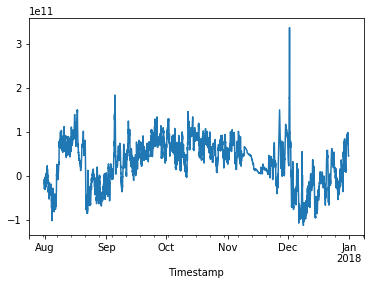

In [21]:
y_pred.plot()

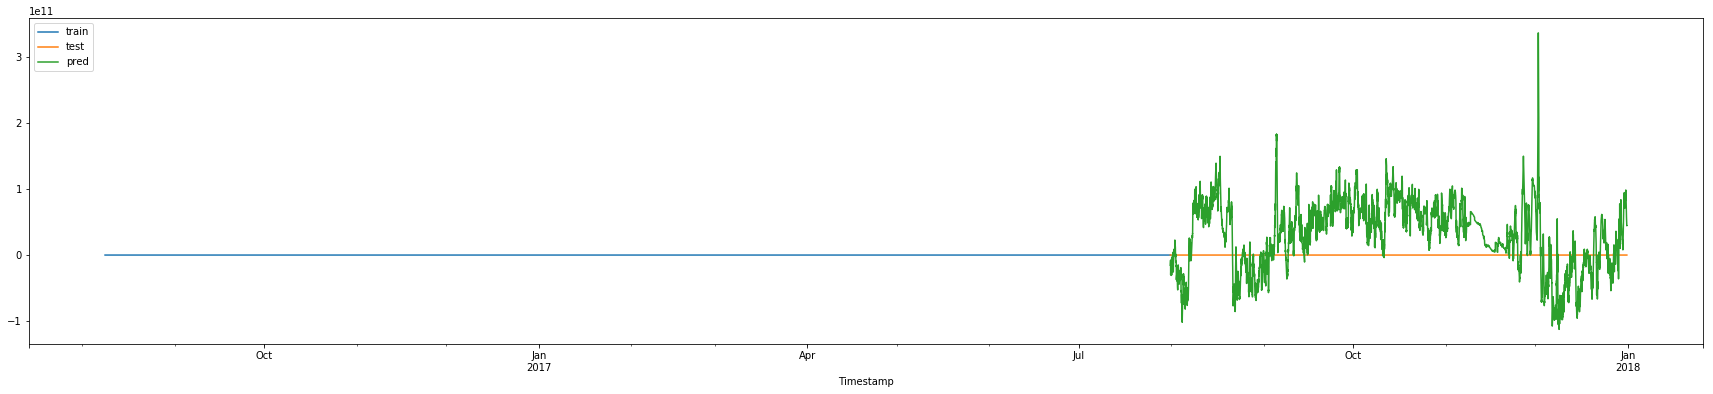

In [22]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [23]:
stacked_M1 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [24]:
stacked_M1.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [25]:
y_pred_tr = stacked_M1.predict(x_tr.values)
y_pred_val = stacked_M1.predict(x_ts.values)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [27]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [28]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 3.902432558264018e+21 test: 2.861952760268284e+21
RMSE train: 62469453001.159035 test: 53497221986.45724
MAE train: 49754627431.08022 test: 43262174857.40622
R2 train: -1.4439332810038503e+20 test: -8.022236344587752e+19


In [29]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

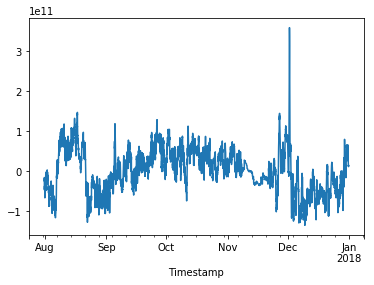

In [30]:
y_pred.plot()

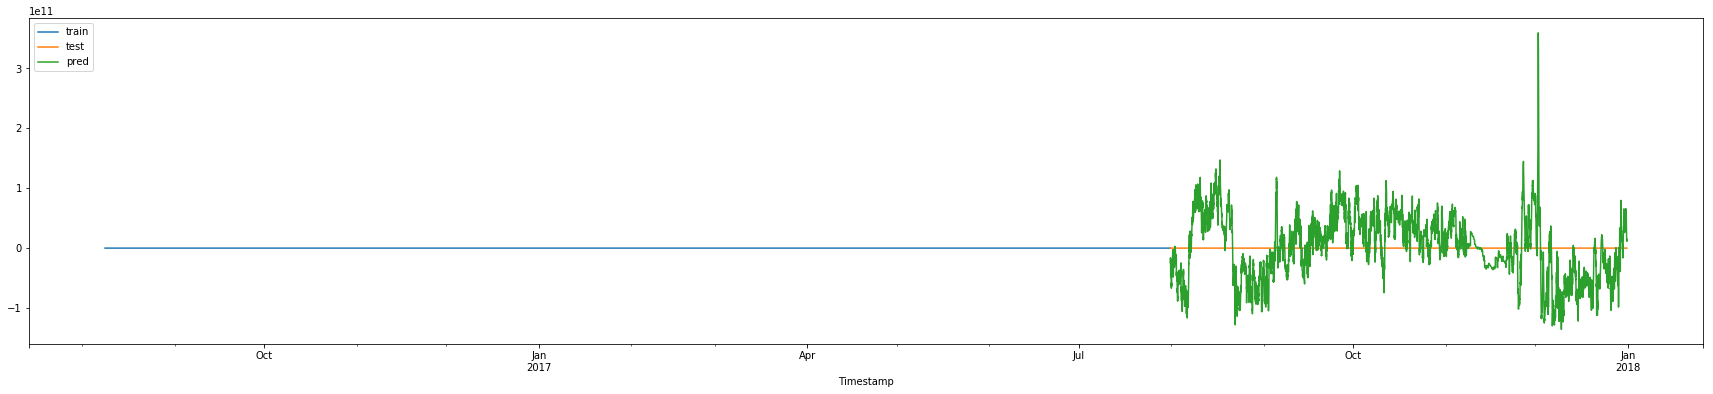

In [31]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [32]:
stacked_M2 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [33]:
stacked_M2.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...recompute=False,
      random_state=123123, selection='cyclic', tol=0.0001,
      warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [34]:
y_pred_tr = stacked_M2.predict(x_tr.values)
y_pred_val = stacked_M2.predict(x_ts.values)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [36]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [37]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 1.9685454455752053e+21 test: 4.218000853752821e+21
RMSE train: 44368293246.13699 test: 64946138097.29429
MAE train: 35515303076.56644 test: 52757945789.45345
R2 train: -7.283785796669975e+19 test: -1.1823325744659058e+20


In [38]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

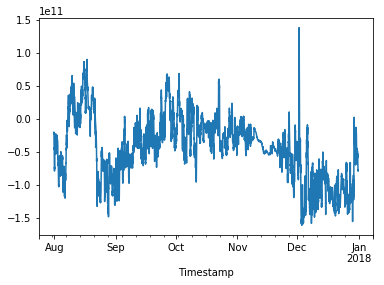

In [39]:
y_pred.plot()

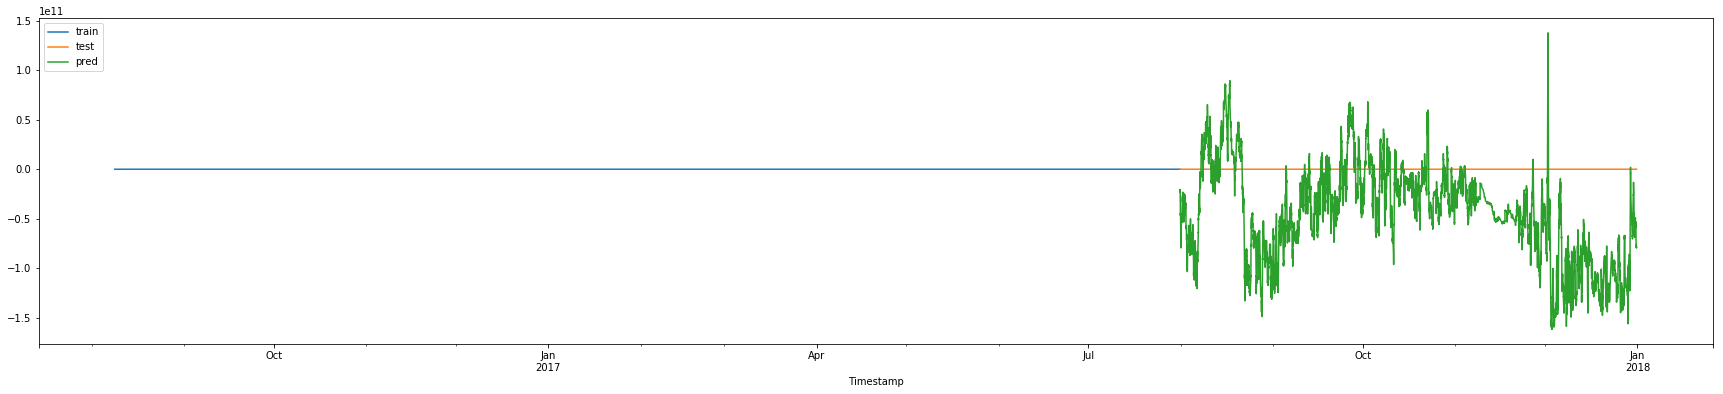

In [40]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [41]:
stacked_M3 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=False)

In [42]:
stacked_M3.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [43]:
y_pred_tr = stacked_M3.predict(x_tr.values)
y_pred_val = stacked_M3.predict(x_ts.values)

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [45]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [46]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 2.833608934186218e+20 test: 6.913052881203635e+20
RMSE train: 16833326867.218548 test: 26292685068.671925
MAE train: 11733278185.588552 test: 19780473463.432034
R2 train: -1.0484594376286763e+19 test: -1.937772867727214e+19


In [47]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

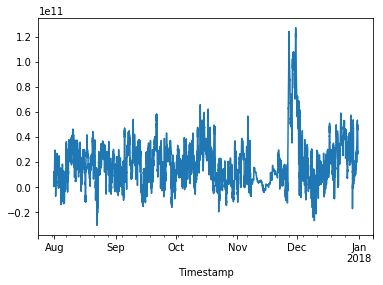

In [48]:
y_pred.plot()

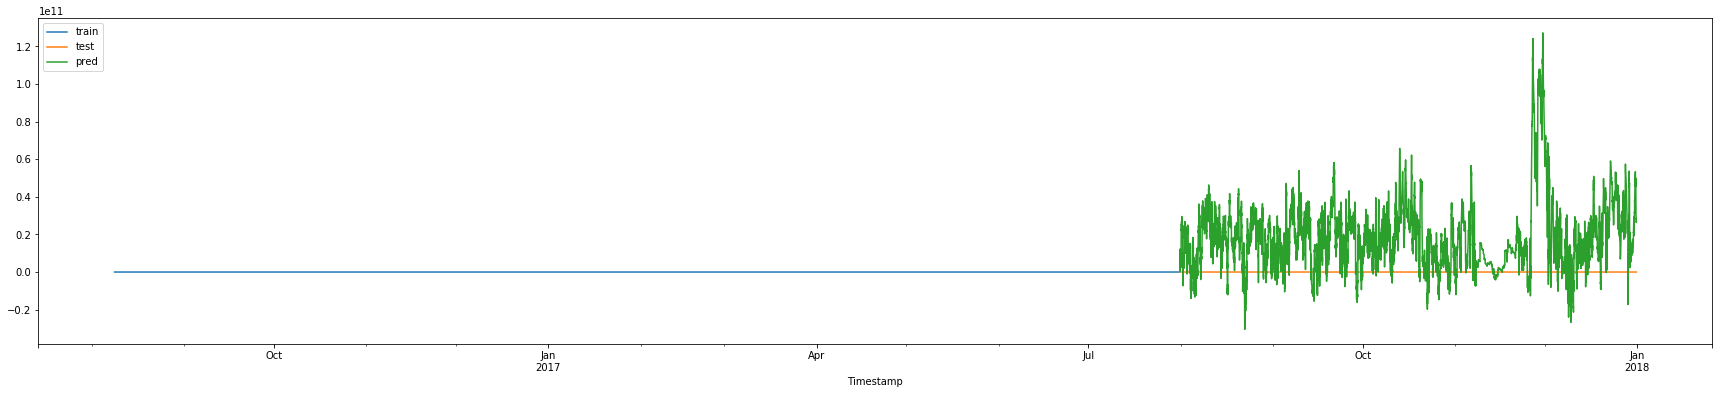

In [49]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [50]:
stacked_M4 = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=False)

In [51]:
stacked_M4.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...recompute=False,
      random_state=123123, selection='cyclic', tol=0.0001,
      warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [52]:
y_pred_tr = stacked_M4.predict(x_tr.values)
y_pred_val = stacked_M4.predict(x_ts.values)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [54]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [55]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 3.7885484024167576e+20 test: 2.5259189166245734e+20
RMSE train: 19464193798.913834 test: 15893139767.285046
MAE train: 13279287918.524057 test: 12457254943.137842
R2 train: -1.4017951734640652e+19 test: -7.080312022525432e+18


In [56]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

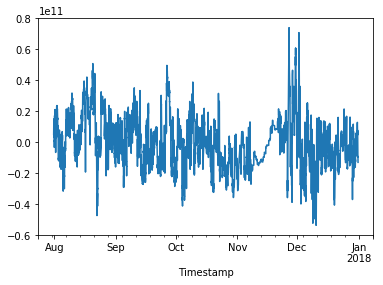

In [57]:
y_pred.plot()

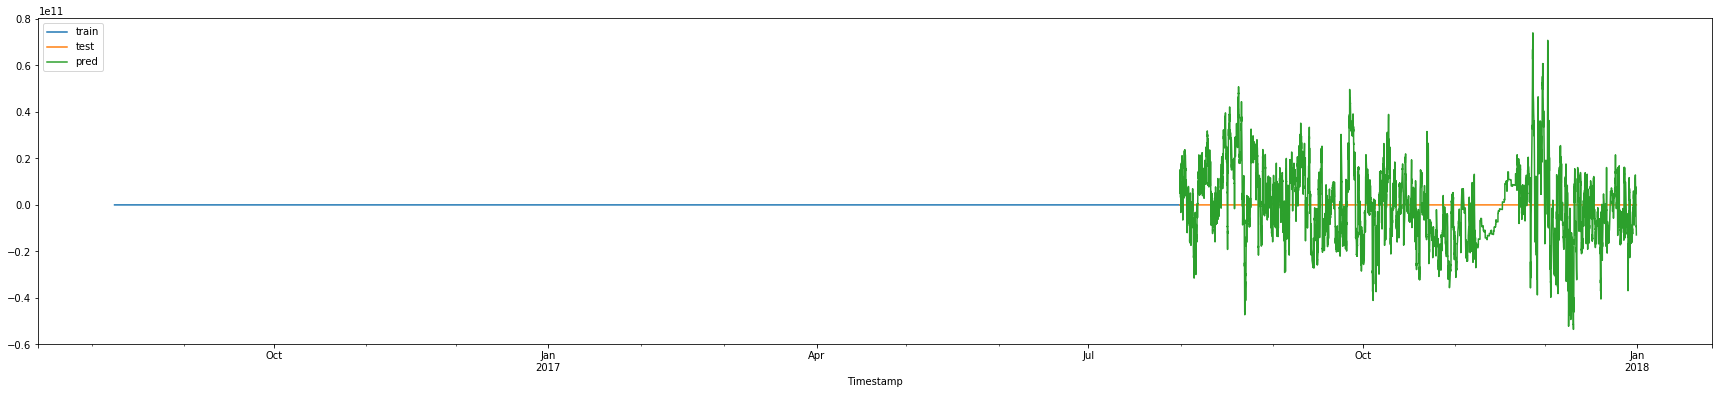

In [58]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [59]:
stacked_M1_enet = StackingCVRegressor(regressors=(ada,ext,xgb_t,rdg,lr,enet,svr_g),
                             meta_regressor=meta_enet,
                             cv=tscv,
                             use_features_in_secondary=True)

In [60]:
stacked_M1_enet.fit(x_tr.values,y_tr.values)

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123123, selection='cyclic', tol=0.0001,
      warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu..., epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [61]:
y_pred_tr = stacked_M1_enet.predict(x_tr.values)
y_pred_val = stacked_M1_enet.predict(x_ts.values)

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [63]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [64]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 23.353183287140567 test: 48.62118850961949
RMSE train: 4.8325131440215 test: 6.972889538033676
MAE train: 3.500418370774577 test: 5.563822569170785
R2 train: 0.13591233000870684 test: -0.3628829622692933


In [65]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

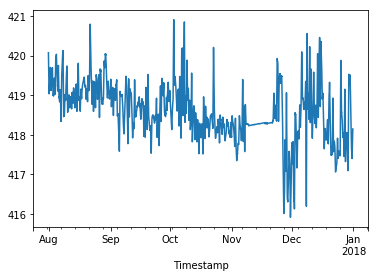

In [66]:
y_pred.plot()

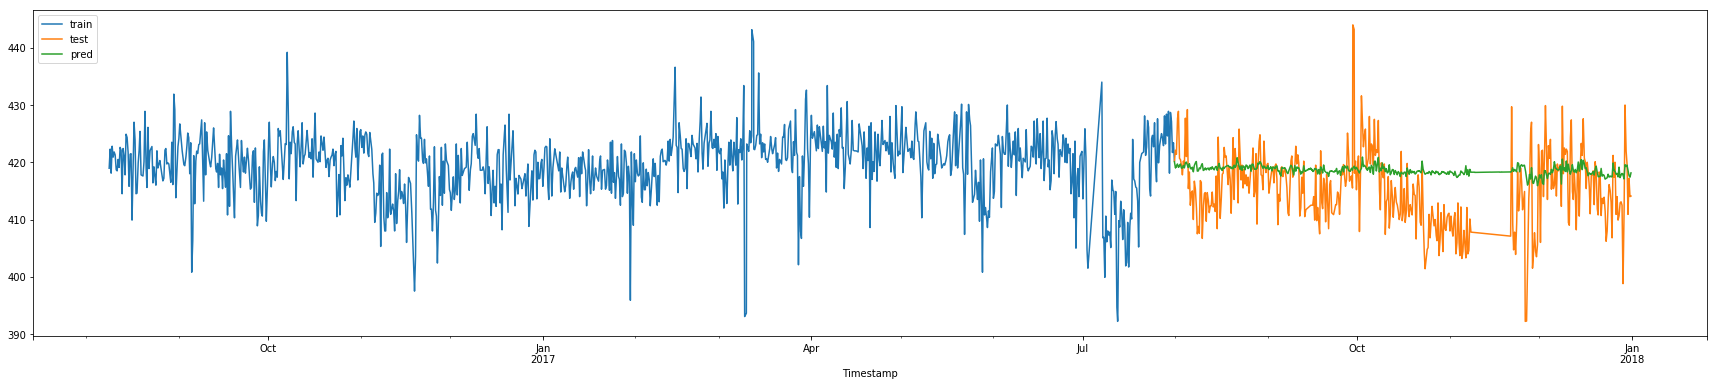

In [67]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [68]:
stacked_M5 = StackingCVRegressor(regressors=(ada,ext,xgb_t),
                             meta_regressor=meta_sgdr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [69]:
stacked_M5.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=SGDRegressor(alpha=0.5, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='squared_loss', max_iter=1000, n_iter=None, penalty='l1',
       power_t=0.25, random_state=123123, shuffle=True, tol=None,
       verbose=0, warm_start=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...23123, reg_alpha=0, reg_lambda=0.3,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [70]:
y_pred_tr = stacked_M5.predict(x_tr.values)
y_pred_val = stacked_M5.predict(x_ts.values)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [72]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [73]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 1.1861638272519277e+22 test: 1.3378852235199436e+22
RMSE train: 108911148522.63416 test: 115666988528.27213
MAE train: 75630250156.77238 test: 95076445866.45152
R2 train: -4.388907178587775e+20 test: -3.750177715722495e+20


In [74]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

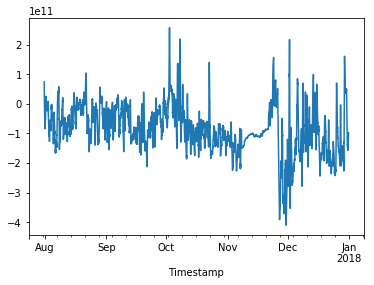

In [75]:
y_pred.plot()

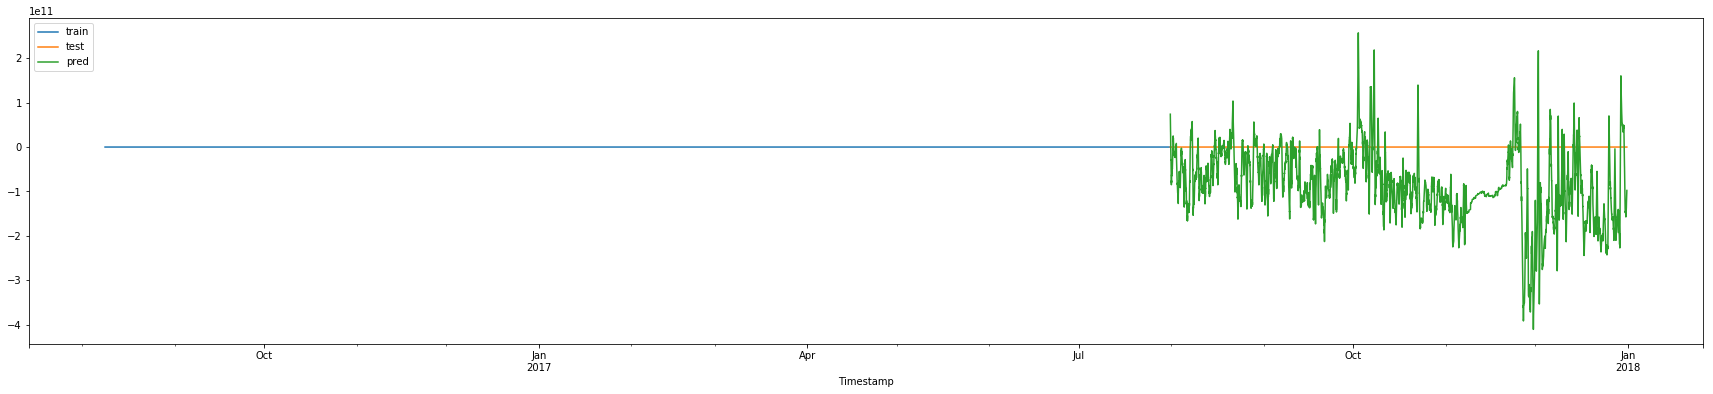

In [76]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [77]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [78]:
metaxg = XGBRegressor(objective="reg:linear",
                 eta=0.02,
                 min_child_weight=8,
                 subsample=0.9,
                 colsample_bytree=0.8,
                 silent=1,
                 max_depth=8,
                 seed=NB_SEED,
                 n_jobs=-1)
metalr = LinearRegression(n_jobs=-1)

In [81]:
stacked_M6_metaxgblin = StackingCVRegressor(regressors=(ada,ext,xgb_t),
                             meta_regressor=metaxg,
                             cv=tscv,
                             use_features_in_secondary=True)

In [82]:
stacked_M6_metaxgblin.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.02, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123123, silent=1, subsample=0.9),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...23123, reg_alpha=0, reg_lambda=0.3,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)),
          shuffle=True, store_train_meta_features=False,
          u

In [83]:
y_pred_tr = stacked_M6_metaxgblin.predict(x_tr.values)
y_pred_val = stacked_M6_metaxgblin.predict(x_ts.values)

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [85]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [86]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 2.707863875719294 test: 37.905286415075906
RMSE train: 1.645558833867478 test: 6.156726923867576
MAE train: 1.1766562913165162 test: 4.776111444419636
R2 train: 0.8998067304891875 test: -0.0625093836368038


In [87]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

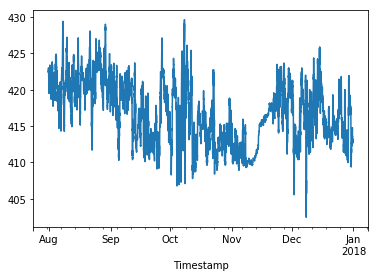

In [88]:
y_pred.plot()

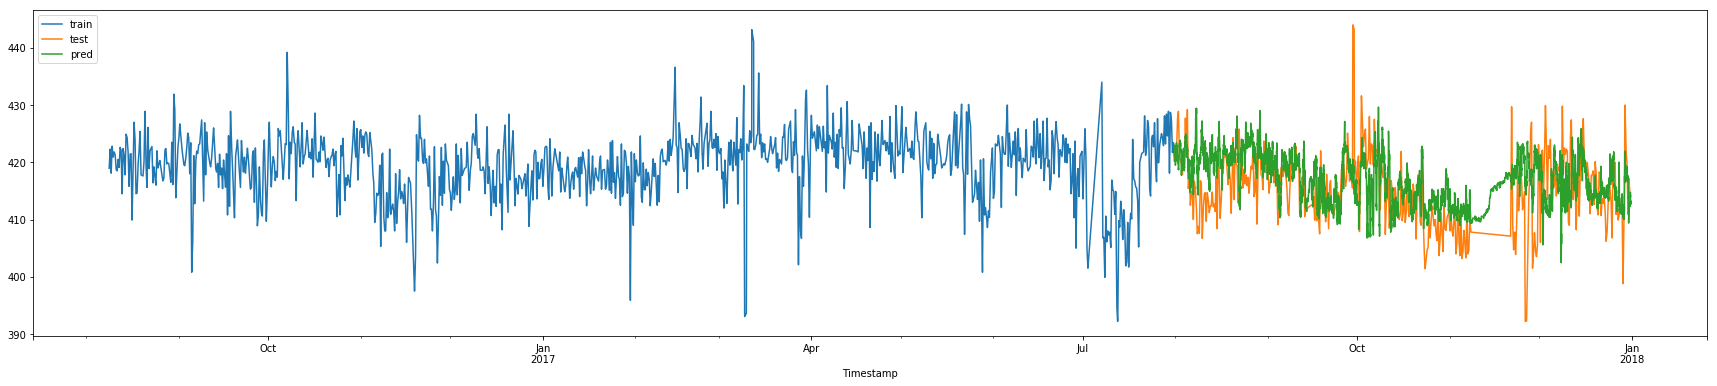

In [89]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')

In [90]:
metaxg = XGBRegressor(objective="reg:linear",
                 eta=0.02,
                 min_child_weight=8,
                 subsample=0.9,
                 colsample_bytree=0.8,
                 silent=1,
                 max_depth=8,
                 seed=NB_SEED,
                 n_jobs=-1)
metalr = LinearRegression(n_jobs=-1)

In [91]:
stacked_M6_metalr = StackingCVRegressor(regressors=(ada,ext,xgb_t),
                             meta_regressor=metalr,
                             cv=tscv,
                             use_features_in_secondary=True)

In [92]:
stacked_M6_metalr.fit(x_tr.values,y_tr.values)

StackingCVRegressor(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          meta_regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
          refit=True,
          regressors=(AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=123123), ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impu...23123, reg_alpha=0, reg_lambda=0.3,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [93]:
y_pred_tr = stacked_M6_metalr.predict(x_tr.values)
y_pred_val = stacked_M6_metalr.predict(x_ts.values)

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def print_metric(metrictr, metricts ,mname):
    print(mname +' train: ' + str(metrictr) + ' test: ' + str(metricts))

In [95]:
mse_tr = mean_squared_error(y_tr.values, y_pred_tr)
rmse_tr = np.sqrt(mse_tr)
mae_tr = mean_absolute_error(y_tr.values, y_pred_tr)
r2_tr=r2_score(y_tr, y_pred_tr)
mse_ts = mean_squared_error(y_ts.values, y_pred_val)
rmse_ts = np.sqrt(mse_ts)
mae_ts = mean_absolute_error(y_ts.values, y_pred_val)
r2_ts = r2_score(y_ts.values, y_pred_val)

In [96]:
print_metric(mse_tr,mse_ts,'MSE')
print_metric(rmse_tr,rmse_ts,'RMSE')
print_metric(mae_tr,mae_ts,'MAE')
print_metric(r2_tr,r2_ts,'R2')

MSE train: 18.43060236901514 test: 27.784144589178755
RMSE train: 4.293087742990486 test: 5.27106674110457
MAE train: 3.0494182538293395 test: 4.0865958673708125
R2 train: 0.31805201621708834 test: 0.22119268486564103


In [97]:
y_pred = pd.Series(data=y_pred_val, index=y_ts.index)

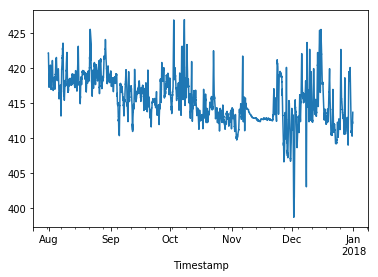

In [98]:
y_pred.plot()

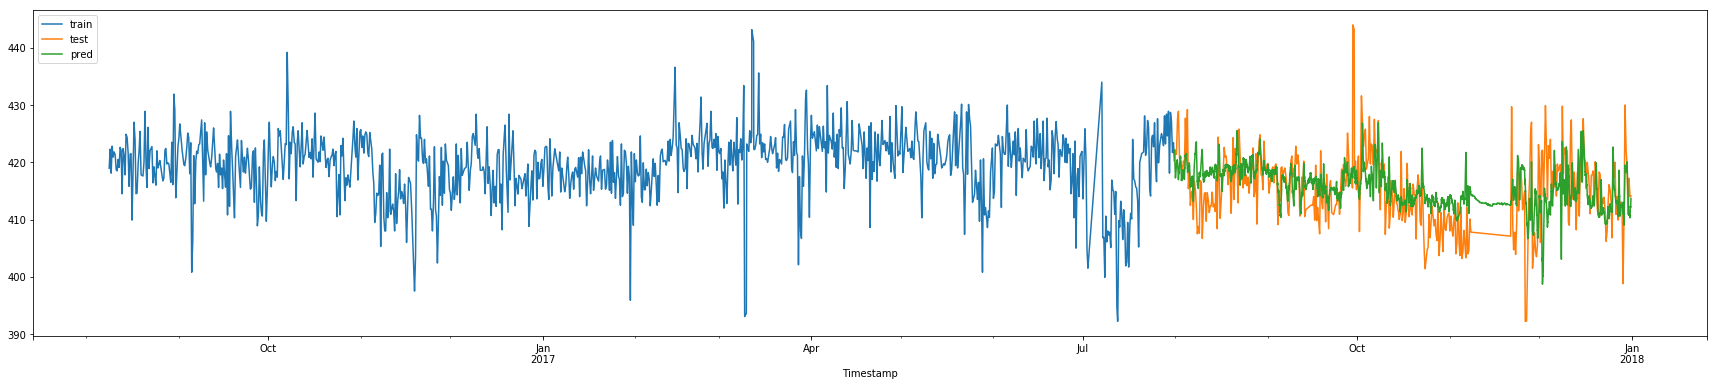

In [99]:
fig, ax = plt.subplots(figsize=(30,6))
y_tr.plot(label='train')
y_ts.plot(label='test')
y_pred.plot(label='pred')
plt.legend(loc='upper left')